# Dictionary Initialization

In [8]:
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the RW predictor
ewMeanRegretValues = []
ewMeanlogLikelihoodValues = []

# Import Data

In [9]:
from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)
from performanceMeasurement import * # this file contains the implementation of the performance measurement functions(like rmse, loglikelihood, regret, etc)

# Validation Phase for expanding window predictor

ok everything works fine; at the moment i will not tune the model(there aren't parameters or hyperparameters), i just measure its performance. so i will use just the test dataset in order to have a fair evaluation of the model with respect to the performance of the other models(RW,EWMA,MGARCH) 

# Test Phase for expanding window predictor

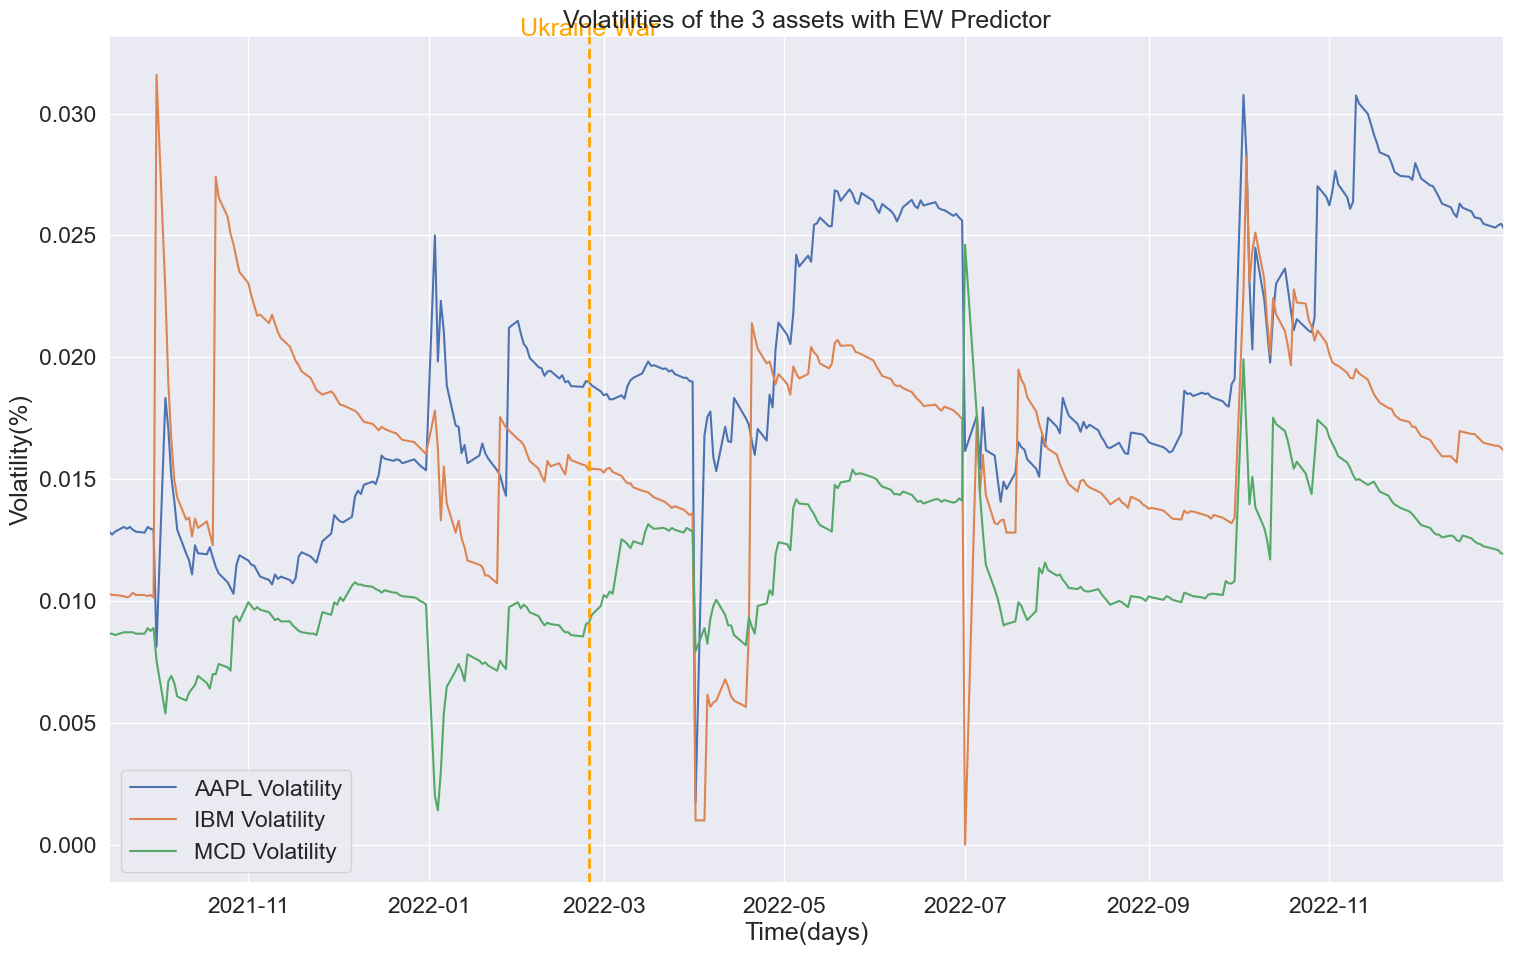

In [10]:
# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

df_ew_volatility_aapl, df_ew_volatility_ibm, df_ew_volatility_mcd, ew_volatility_dict_aapl, ew_volatility_dict_ibm, ew_volatility_dict_mcd = plot_volatility(expandingWindowDict, real_volatility_startDate, real_volatility_endDate, 'EW')

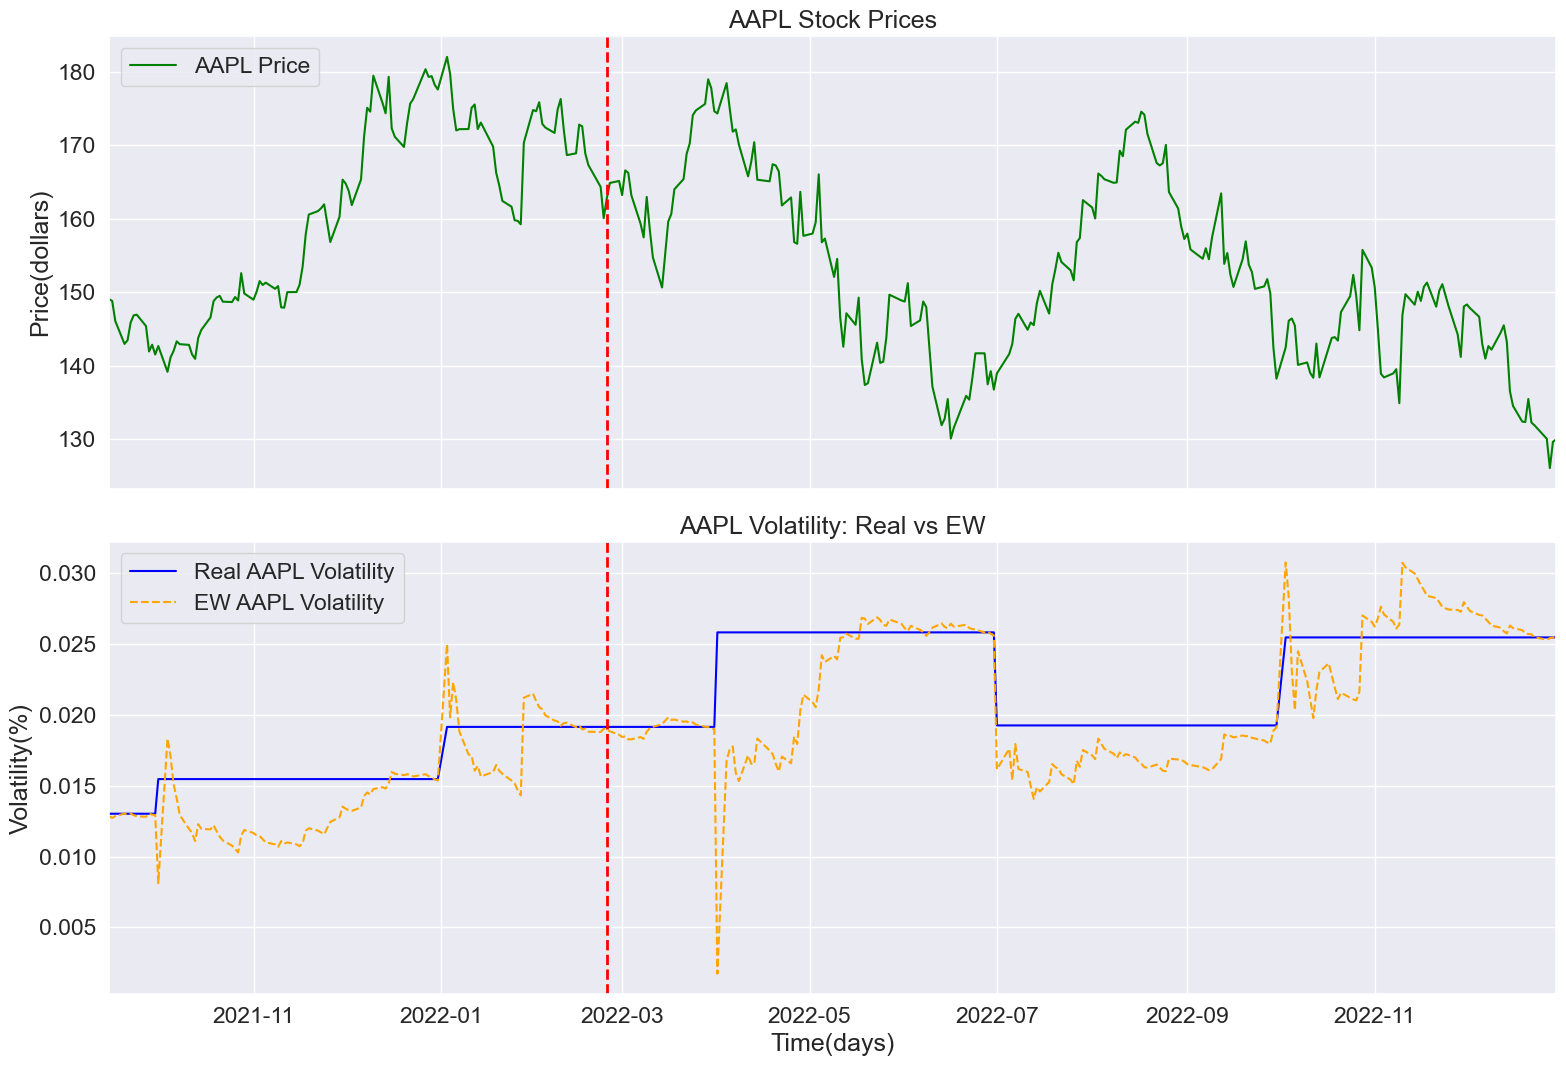

In [11]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ew_volatility_aapl['AAPL Volatility'], 'AAPL', "EW")

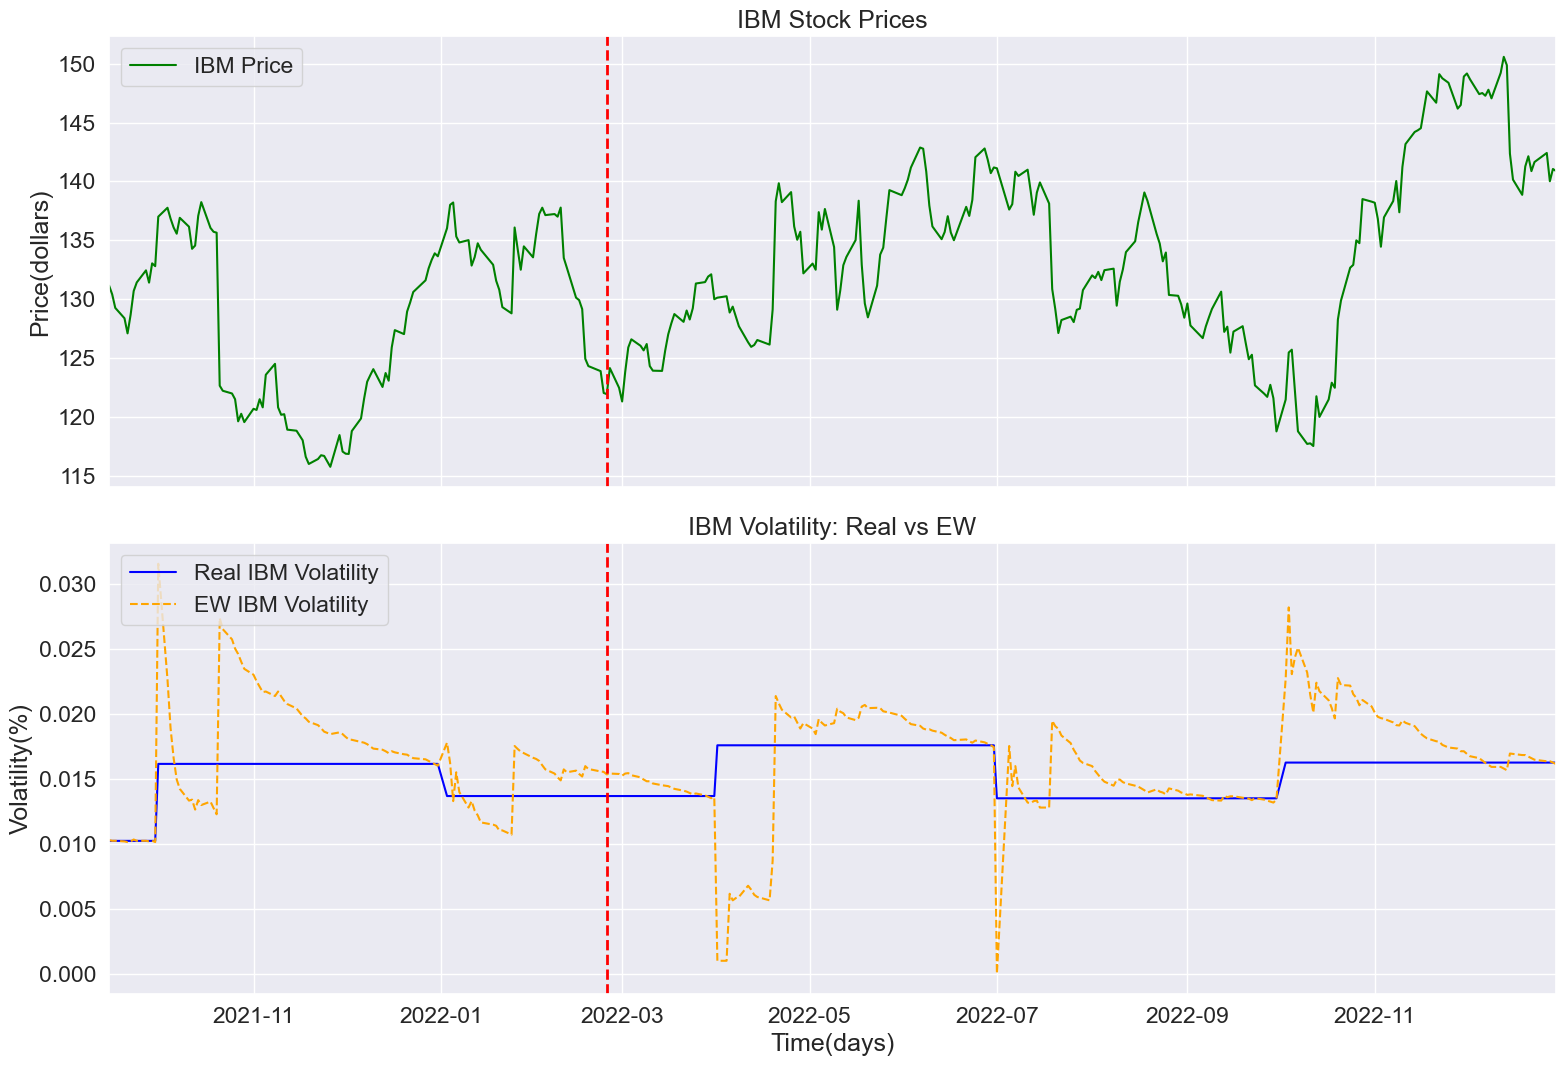

In [12]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_ew_volatility_ibm['IBM Volatility'], 'IBM', "EW")

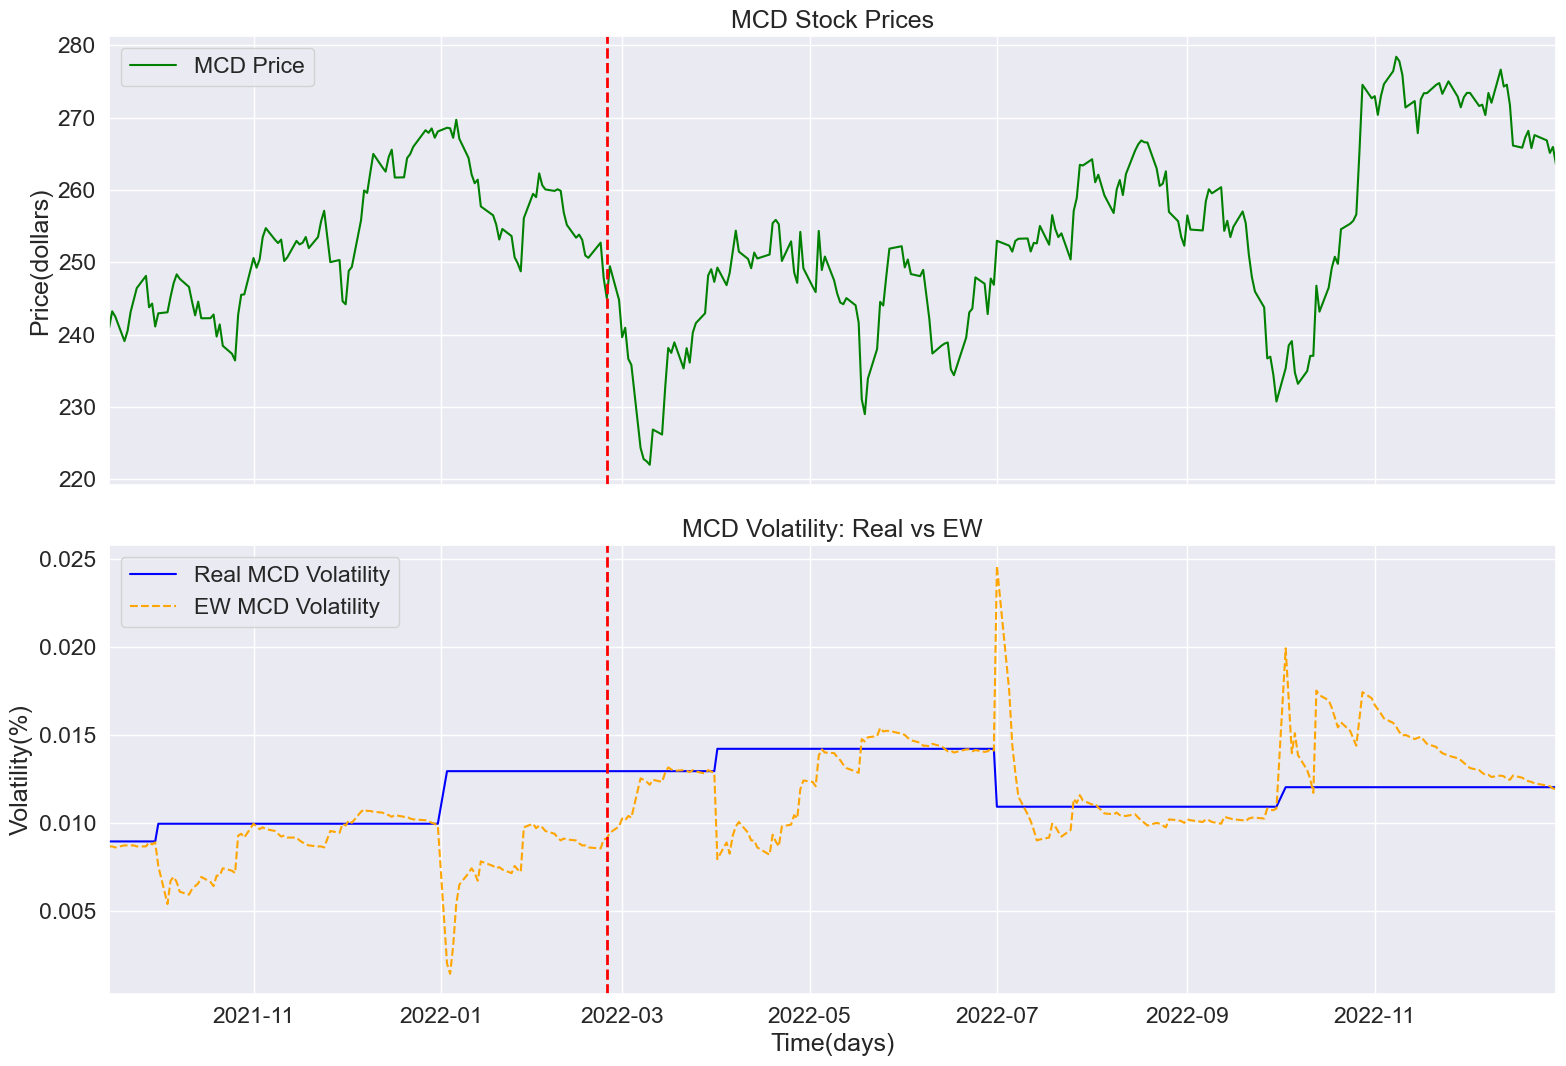

In [13]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_ew_volatility_mcd['MCD Volatility'], 'MCD', "EW")

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2


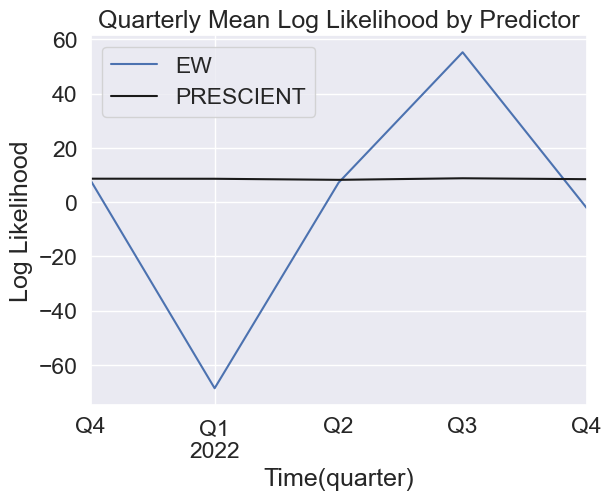



meanRegret: 8.600
stdRegret: 39.700
maxRegret: 77.300


meanLoglikelihoodEW: -0.100
stdLoglikelihoodEW: 39.700
maxLoglikelihoodEW: 55.300


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800
lenght of prescientDict:  308
lenght of expandingWindowDict:  308
lenght of predictorDict:  308

EW RMSE
mean: 0.0161949982
std: 0.0025900325
max: 0.0195509917
lenght of rmses:  5
values of rmses:  {Timestamp('2022-01-02 00:00:00'): 0.01376253008880431, Timestamp('2022-03-31 00:00:00'): 0.013659881165437655, Timestamp('2022-06-30 00:00:00'): 0.019550991695732732, Timestamp('2022-10-02 00:00:00'): 0.014922776207497126, Timestamp('2022-12-29 00:00:00'): 0.01907881191870825}


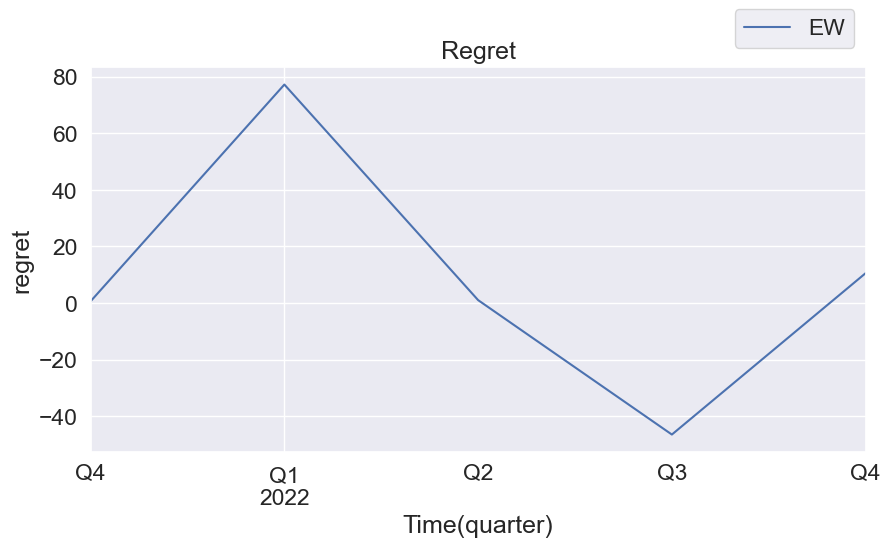

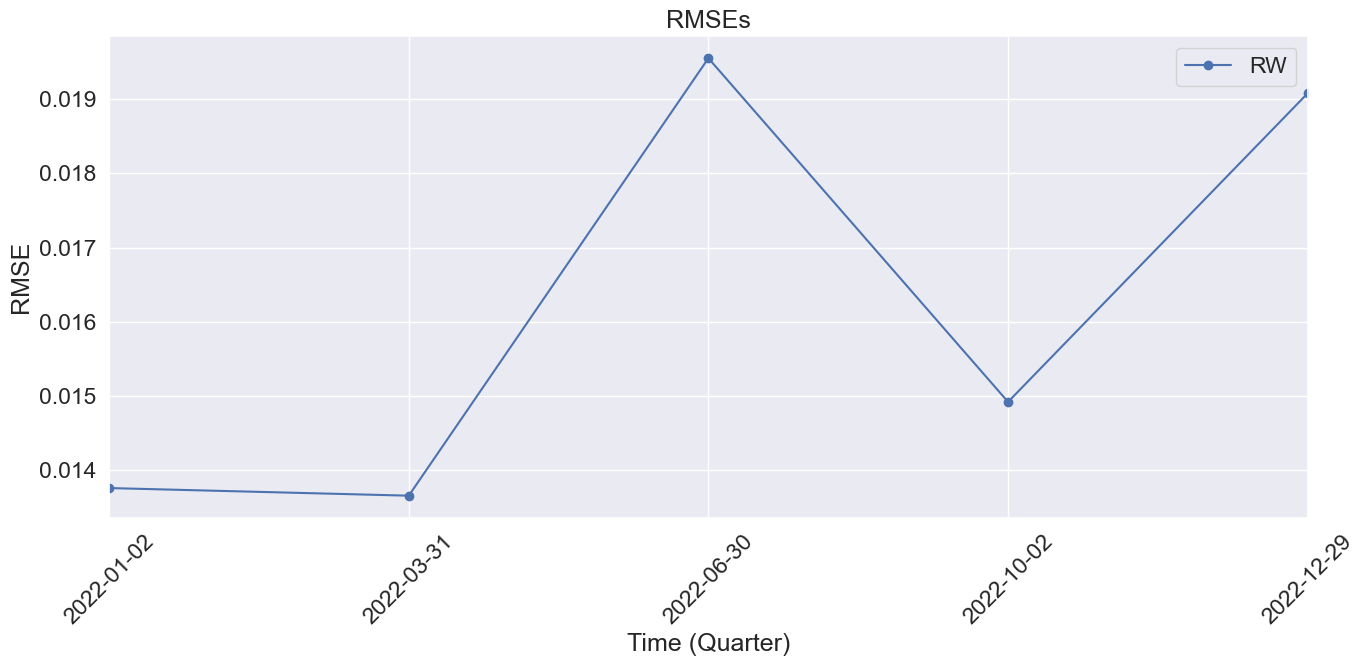

In [14]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["EW", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [expandingWindowDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


expandingWindowDict = predictors[0]
expandingWindowDict = {k: expandingWindowDict[k] for k in list(expandingWindowDict)[19:]}
predictors[0] = expandingWindowDict

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDict = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDict = {k: prescientDict[k] for k in list(prescientDict)[19:]}
predictors[1] = prescientDict

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

# if we are here, it means that the two predictors have the same length and the same timestamps so i can measure the performance of the two predictors


#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

daily_log_likelihoods = predictorLogLikelihood(testDataWithPercentageChange, predictors, names)

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
predictorRegret(daily_log_likelihoods, names)

#
# RMSEs
#

print("lenght of prescientDict: ", len(prescientDict))
print("lenght of expandingWindowDict: ", len(expandingWindowDict))
        
RMSEcovarianceMatrix(testDataWithPercentageChange, predictors, prescientDict, start_date, names)